In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

df  = pd.read_csv(r"C:\Users\ab665\OneDrive\Desktop\ML-AI\creditcard.csv")[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

In [3]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

171

In [4]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter = 1000),
    param_grid={'class_weight': [{0:1, 1:v} for v in range(1,4)]},
    cv=4,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [5]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.778425,0.148077,0.004685,0.004826,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,0.711120,0.185088,0.003954,0.005255,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99025,0.99840,0.99960,0.99805,0.996575,0.003697,2
2,0.628917,0.040658,0.002947,0.003235,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y);


In [7]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

make_scorer(min_recall_precision, greater_is_better=False)
# ?make_scorer

make_scorer(min_recall_precision, greater_is_better=False)

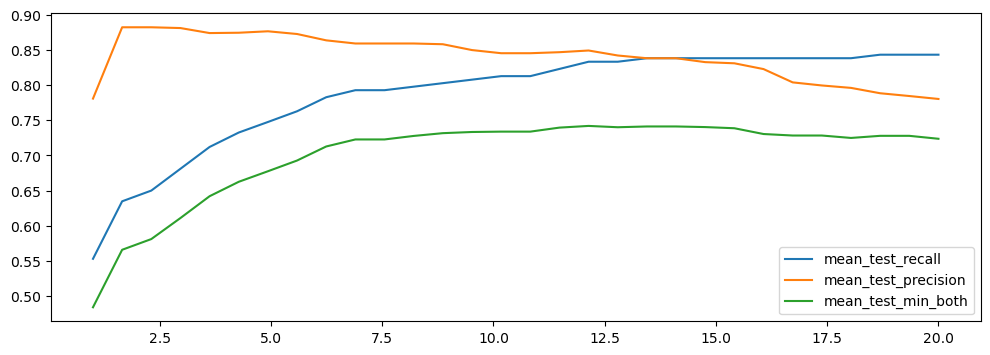

In [8]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();

In [9]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

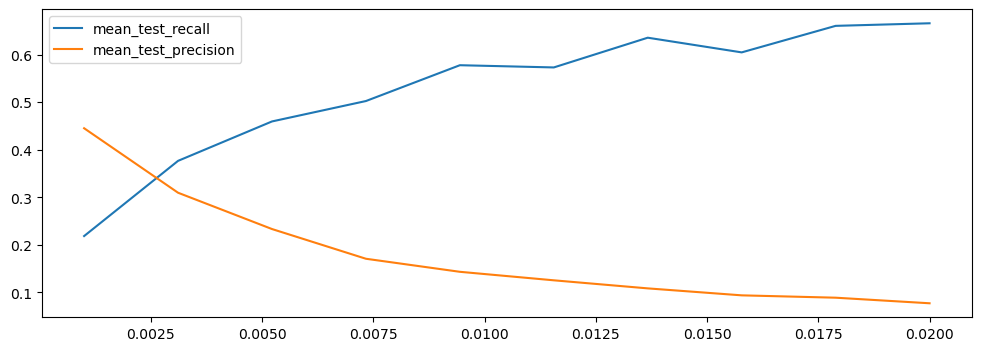

In [10]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y);

plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend();